# ECOM09A Atividade 2 Etapa 4

[Proposta](https://docs.google.com/document/d/e/2PACX-1vS-DZIR4CM_abUC7bgTtd3x5X_QCdh8Y3FdVdEQbTfTRricAduuQK5i_yQIHdMoKddV6g9QONtp-BuN/pub)

(14/06/2024) Utilizando um modelo do Huggingfaces de Text Classification:
- https://huggingface.co/models?pipeline_tag=text-classification
- Obter um resultado melhor que o notebook da etapa 3 (GloVe)

Código abaixo baseado em:

https://medium.com/@prakashram1327/building-a-text-classification-model-using-distilbert-703c1409696c

## Base de dados de artigos da Folha UOL

In [2]:
import os
from IPython.core.display import display, HTML
from google.colab import files, userdata

if not os.path.exists('/content/articles.csv'):
  if not os.path.exists('kaggle.json'):
    try:
      kaggle_key = userdata.get('kaggle_key')
      open('kaggle.json','w').write(kaggle_key)
    except:
      files.upload()

  !pip install -q kaggle

  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !rm kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download 'marlesson/news-of-the-site-folhauol'
  !unzip -qq news-of-the-site-folhauol.zip
  !rm news-of-the-site-folhauol.zip

KeyboardInterrupt: 

## Instalando Biblioteca do HuggingFaces (Transformers)

In [ ]:
!pip install -q datasets transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 52.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have reques

In [ ]:
import transformers
print('Transformes:',transformers.__version__)
import datasets
print('Datasets:',datasets.__version__)

Transformes: 4.41.2
Datasets: 2.20.0


## Carregando Base de Dados no Format Transformes

In [ ]:
import pandas as pd

df_folha = pd.read_csv('articles.csv',encoding="utf8")

df_folha.drop(["title","date","subcategory","link"],axis=1,inplace=True)
df_folha.drop_duplicates(subset=["text"],inplace=True)
df_folha.dropna(inplace=True)

df_folha.reset_index(drop=True,inplace=True)
df_folha = df_folha[df_folha['category'].isin(list(df_folha['category'].value_counts()[:7].index))]

df_folha.head()

,text,category
0,Com a possibilidade de uma condenação impedir ...,poder
1,"Para Oumou Sangaré, cantora e ativista malines...",ilustrada
2,Três reportagens da Folha foram vencedoras do ...,poder
3,A Disney divulgou na noite desta segunda-feira...,ilustrada
4,"O CBSS, banco da holding Elopar dos sócios Bra...",mercado


In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, Value, ClassLabel, Features, DatasetDict
import pandas as pd

labels, class_names = pd.factorize(df_folha['category'], sort=True)
class_names = list(class_names.values)
df_folha['labels'] = labels

train, test = train_test_split(df_folha[['text', 'labels']].sample(n=5000), test_size=0.2, random_state=42)

features = Features({"text": Value("string"), "labels": ClassLabel(names=class_names)})

dataset = DatasetDict({
    "train": Dataset.from_pandas(train, features=features, preserve_index=False),
    "test": Dataset.from_pandas(test, features=features, preserve_index=False)
})

print('dataset =', dataset)
print("dataset['train'].features =", dataset['train'].features)

id2label = {id: label for id, label in enumerate(class_names)}
label2id = {label: id for id, label in id2label.items()}
print('id2label =', id2label)
print('label2id =', label2id)


dataset = DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1000
    })
})
dataset['train'].features = {'text': Value(dtype='string', id=None), 'labels': ClassLabel(names=['colunas', 'cotidiano', 'esporte', 'ilustrada', 'mercado', 'mundo', 'poder'], id=None)}
id2label = {0: 'colunas', 1: 'cotidiano', 2: 'esporte', 3: 'ilustrada', 4: 'mercado', 5: 'mundo', 6: 'poder'}
label2id = {'colunas': 0, 'cotidiano': 1, 'esporte': 2, 'ilustrada': 3, 'mercado': 4, 'mundo': 5, 'poder': 6}


In [ ]:
dataset['train'][7]['text'], dataset['train'][7]['labels']

('Se o bom desempenho da Ferrari e o esconde-esconde de Mercedes e Red Bull foram a tônica da primeira bateria de testes pré-temporada, o foco agora é outro.  A McLaren.  Em Barcelona, que desde ontem recebe a segunda sessão de treinos, a curiosidade está concentrada nos carros de Button e Alonso. E nos motores japoneses que os empurram.  Quaisquer que sejam os resultados na pista, boa parte das notícias de F-1 no domingo levarão nos enunciados o nome da equipe inglesa. Para o bem ou para o mal.  O motivo remete a Jerez de la Frontera.  Lá, o primeiro ensaio da retomada do binômio McLaren-Honda foi um retumbante fracasso.  Enquanto a Mercedes percorreu 2.280 km, a McLaren só conseguiu completar 350 km. Foi a mais lenta todos os dias. Sua melhor marca, obtida por Button, foi 6s8 pior que o tempo de Raikkonen, que comandou a sessão. Um abismo.  Para a Honda, que não fornece motor para mais ninguém, o resultado foi ainda mais calamitoso. Carros empurrados pelos Mercedes coletaram dados po

## Modelo Neural

In [ ]:
model_checkpoint = 'bert-base-uncased' # não usar o 'distilbert-base-uncased'
batch_size = 16

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer(dataset['train'][7]['text'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (948 > 512). Running this sequence through the model will result in indexing errors


{'input_ids': [101, 7367, 1051, 8945, 2213, 4078, 6633, 11837, 6806, 4830, 13632, 1041, 1051, 9686, 8663, 3207, 1011, 9686, 8663, 3207, 2139, 10793, 1041, 2417, 7087, 2005, 3286, 1037, 28157, 2050, 4830, 3539, 7895, 7151, 11610, 2139, 3231, 2229, 3653, 1011, 13657, 28510, 1010, 1051, 1042, 24163, 3283, 2527, 1041, 2041, 3217, 1012, 1037, 18590, 1012, 7861, 7623, 1010, 10861, 4078, 3207, 2006, 18532, 28667, 15878, 2063, 1037, 19071, 7367, 11488, 2080, 2139, 29461, 5740, 2015, 1010, 1037, 12731, 9488, 5332, 14697, 2063, 9765, 2050, 9530, 13013, 28510, 16839, 12385, 2891, 2139, 6462, 1041, 17649, 1012, 1041, 16839, 5013, 2229, 14855, 29513, 8583, 10861, 9808, 7861, 5311, 6444, 1012, 24209, 15593, 4226, 2099, 10861, 7367, 3900, 2213, 9808, 2765, 28118, 6583, 14255, 9153, 1010, 8945, 2050, 2112, 2063, 8695, 2025, 24108, 2015, 2139, 1042, 1011, 1015, 2053, 15586, 23310, 5400, 2080, 16839, 4372, 4609, 7405, 12269, 1051, 2053, 4168, 4830, 1041, 15549, 5051, 13749, 4244, 2050, 1012, 11498, 1051

### Convertendo Dataset para Tokens

In [ ]:
def preprocess_function(examples):
  return tokenizer(examples['text'], truncation=True)

encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
})

## Ajuste-Fino

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding

# Load pre-trained DistilBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(class_names))

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
)

# Define Trainer object for training the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

# Save the trained model
trainer.save_model('model')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.806823
2,1.019400,0.661688
3,1.019400,0.618964


## Avaliando Modelo Treinado

In [ ]:
outputs = trainer.predict(encoded_dataset['test'])

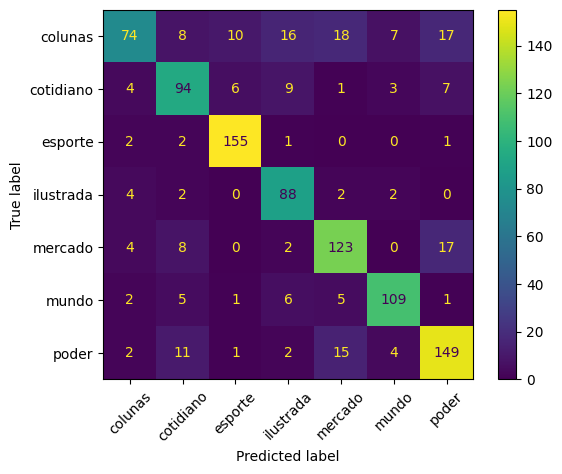

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = encoded_dataset['test'].features['labels'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

     colunas       0.80      0.49      0.61       150
   cotidiano       0.72      0.76      0.74       124
     esporte       0.90      0.96      0.93       161
   ilustrada       0.71      0.90      0.79        98
     mercado       0.75      0.80      0.77       154
       mundo       0.87      0.84      0.86       129
       poder       0.78      0.81      0.79       184

    accuracy                           0.79      1000
   macro avg       0.79      0.80      0.79      1000
weighted avg       0.79      0.79      0.79      1000

